In [1]:
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from utils import load_all_images_3channel, get_class_name

PIXELS = 130

In [2]:
# settings
plt.style.use('seaborn')
plt.show()
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (8, 5)

In [3]:
x, y = load_all_images_3channel(
    classes=["sunny", "cloudy", "foggy", "rainy", "snowy"], pixels=PIXELS
)

 has processed 18039

In [4]:
# make them as numpy array
x = np.array(x)
y = np.array(y)

x.shape, y.shape

((18039, 130, 130, 3), (18039,))

In [5]:
# shuffle and split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, shuffle=True, random_state=777
)

y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

# convert class vector into binary matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train.shape, y_train.shape

((12627, 130, 130, 3), (12627, 5))

# Feature extraction
## CNN with 3-Color Channels

In [6]:
model = Sequential([
    # keras.Input(shape=(PIXELS, PIXELS, 3)),    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(PIXELS, PIXELS, 3)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=5, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 53824)             0

2022-08-21 17:11:55.292486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 17:11:55.293412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 17:11:55.294254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 17:11:55.295089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 17:11:55.301623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [7]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [8]:
# train model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=3, min_delta=0.0001, restore_best_weights=True),
        ReduceLROnPlateau(patience=1, factor=0.1)
    ],
)

Epoch 1/20


2022-08-21 17:12:02.776234: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-08-21 17:12:03.779862: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-21 17:12:04.671807: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


316/316 [==============================] - 8s 13ms/step - loss: 1.2782 - accuracy: 0.5353 - val_loss: 1.0296 - val_accuracy: 0.5835 - lr: 0.0010
Epoch 2/20
316/316 [==============================] - 4s 11ms/step - loss: 0.9006 - accuracy: 0.6499 - val_loss: 0.8262 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 3/20
316/316 [==============================] - 4s 12ms/step - loss: 0.8023 - accuracy: 0.6988 - val_loss: 0.8793 - val_accuracy: 0.6639 - lr: 0.0010
Epoch 4/20
316/316 [==============================] - 4s 11ms/step - loss: 0.5854 - accuracy: 0.7785 - val_loss: 0.7174 - val_accuracy: 0.7344 - lr: 1.0000e-04
Epoch 5/20
316/316 [==============================] - 4s 12ms/step - loss: 0.5396 - accuracy: 0.8006 - val_loss: 0.7189 - val_accuracy: 0.7352 - lr: 1.0000e-04
Epoch 6/20
316/316 [==============================] - 4s 12ms/step - loss: 0.5020 - accuracy: 0.8132 - val_loss: 0.7173 - val_accuracy: 0.7352 - lr: 1.0000e-05
Epoch 7/20
316/316 [==============================] - 4s 12ms/s

170/170 [==============================] - 1s 5ms/step - loss: 0.7069 - accuracy: 0.7380


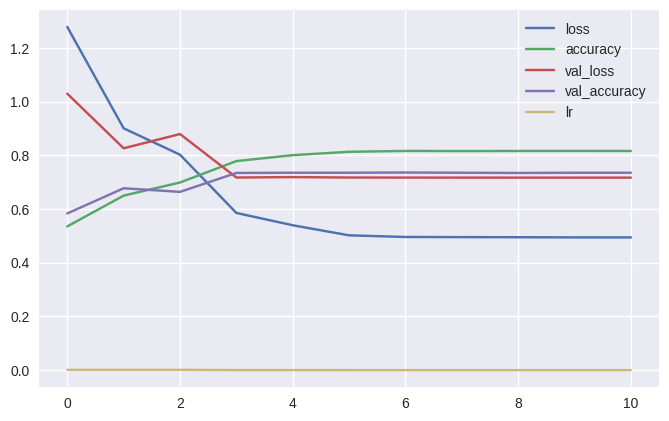

In [9]:
model.evaluate(x_test, y_test)
pd.DataFrame(history.history).plot()
plt.show()

170/170 [==============================] - 1s 4ms/step


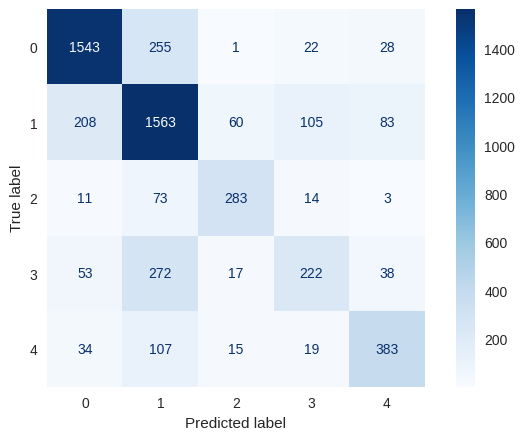

In [10]:
predictions = model.predict(x_test)
pred_values = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test_labels, pred_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()